In [25]:
import torch
import torch.nn.functional as F
import numpy as np
import os, argparse
from scipy import misc
from lib.HSFNet import HSFNet
from utils.dataloader import test_dataset
import cv2
import matplotlib.pyplot as pltf

In [26]:
model = HSFNet()
model.load_state_dict(torch.load("/home/qyl/HSFNet/model_pth/best.pth"))
model.cuda()
model.eval()

HSFNet(
  (backbone): pvt_v2_b2(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (block1): ModuleList(
      (0): Block(
        (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_features=64, out_features=

In [27]:
import torchvision.transforms as transforms
def load_and_preprocess(image_path, target_size=(352, 352)): 
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                             std=[0.229, 0.224, 0.225])
    ])
    return preprocess(image).unsqueeze(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'  

In [28]:
dummy_path = "/home/qyl/dataset/Polyp_dataset/TestDataset/CVC-300/images/154.png"
dummy_input = load_and_preprocess(dummy_path).cuda()
num_warmup = 50
num_iter = 100

print(f"Warming up for {num_warmup} iterations...")
with torch.no_grad():
    for _ in range(num_warmup):
        _,_,_,_ = model(dummy_input)

if device == 'cuda':
    torch.cuda.synchronize()

import time
timings = []
print(f"Testing for {num_iter} iterations...")
with torch.no_grad():
    for _ in range(num_iter):
        start_time = time.perf_counter()  # 高精度计时
        
        p1,p2,p3,p4 = model(dummy_input)
        res = p1+p2+p3+p4
        if device == 'cuda':
            torch.cuda.synchronize()
        
        end_time = time.perf_counter()
        timings.append(end_time - start_time)


timings = np.array(timings)
avg_time = np.mean(timings)
std_time = np.std(timings)
fps = 1.0 / avg_time

print("\n=== Benchmark Results ===")
print(f"Device: {device.upper()}")
print(f"Average inference time: {avg_time*1000:.2f}ms ± {std_time*1000:.2f}ms")
print(f"FPS: {fps:.2f}")
print(f"Max FPS: {1.0/np.min(timings):.2f}")
print(f"Min FPS: {1.0/np.max(timings):.2f}")

Warming up for 50 iterations...
Testing for 100 iterations...

=== Benchmark Results ===
Device: CUDA
Average inference time: 11.01ms ± 0.27ms
FPS: 90.83
Max FPS: 93.74
Min FPS: 83.89


In [31]:
"""
Here we use torchview to visualize the structure of our model.
"""

from torchview import draw_graph
from IPython.display import Image, display
model = HSFNet()
graph = draw_graph(model, input_size=(1, 3, 352, 352))
graph.visual_graph.render("HSFNet_structure", format="png")
display(Image(filename="HSFNet_structure.png"))


(process:21436): Pango-WARNING **: 16:20:05.251: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


In [30]:
"""
FFE module
"""
import torch.nn as nn
from lib.conv_block import SELayer
class _FrequencyMix(nn.Module):

    def __init__(self, 
                in_channels,
                k_list=[2],
                # freq_list=[2, 3, 5, 7, 9, 11],
                fs_feat='feat',
                lp_type='freq_channel_att',
                act='sigmoid',
                channel_res=True,
                spatial='conv',
                spatial_group=1,
                compress_ratio=16,
                ):
        super().__init__()
        k_list.sort()
        # print()
        self.k_list = k_list
        # self.freq_list = freq_list
        self.lp_list = nn.ModuleList()
        self.freq_weight_conv_list = nn.ModuleList()
        self.fs_feat = fs_feat
        self.lp_type = lp_type
        self.in_channels = in_channels
        self.channel_res = channel_res
        if spatial_group > 64: spatial_group=in_channels
        self.spatial_group = spatial_group
        if spatial == 'conv':
            self.freq_weight_conv = nn.Conv2d(in_channels=in_channels, 
                                            out_channels=(len(k_list) + 1) * self.spatial_group, 
                                            stride=1,
                                            kernel_size=3, padding=1, bias=True) 
            # self.freq_weight_conv.weight.data.zero_()
            # self.freq_weight_conv.bias.data.zero_()   
        elif spatial == 'cbam': 
            self.freq_weight_conv = SpatialGate(out=len(k_list) + 1)
        else:
            raise NotImplementedError
        
        if self.lp_type == 'avgpool':
            for k in k_list:
                self.lp_list.append(nn.Sequential(
                nn.ReflectionPad2d(padding= k // 2),
                # nn.ZeroPad2d(padding= k // 2),
                nn.AvgPool2d(kernel_size=k, padding=0, stride=1)
            ))
        elif self.lp_type == 'freq':
            pass
        elif self.lp_type in ('freq_channel_att', 'freq_channel_att_reduce_high'):
            # self.channel_att= nn.ModuleList()
            # for i in 
            self.channel_att_low = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(self.in_channels, self.in_channels // compress_ratio, kernel_size=1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(self.in_channels // compress_ratio, self.in_channels, kernel_size=1, padding=0, bias=True),
                nn.Sigmoid()
            )
            # self.channel_att_low[3].weight.data.zero_()
            # self.channel_att_low[3].bias.data.zero_()

            self.channel_att_high = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(self.in_channels, self.in_channels // compress_ratio, kernel_size=1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(self.in_channels // compress_ratio, self.in_channels, kernel_size=1, padding=0, bias=True),
                nn.Sigmoid()
            )

        elif self.lp_type in ('freq_channel_se', ):

            self.channel_att = SELayer(self.in_channels, ratio=16)
        else:
            raise NotImplementedError
        
        self.act = act
        # self.freq_weight_conv_list.append(nn.Conv2d(self.deform_groups * 3 * self.kernel_size[0] * self.kernel_size[1], 1, kernel_size=1, padding=0, bias=True))
        self.freq_thres=0.25 * 1.4

    def forward(self, x):
        freq_weight = self.freq_weight_conv(x)   #  [8 2 11 11]
        
        if self.act == 'sigmoid':      
            freq_weight = freq_weight.sigmoid()  #  freq_weight
        else:
            raise NotImplementedError
        x_fft = torch.fft.fftshift(torch.fft.fft2(x))  # [8, 512, 11, 11] Corresponding to Equations (1) and (2) in Section 3.2
        low_mask = torch.zeros_like(x_fft, device=x_fft.device) # 创建与x_fft相同的张量，并存储在一样的位置
        high_mask = torch.ones_like(x_fft, device=x_fft.device) # 创建与x_fft相同的张量，并存储在一样的位置
        # mask[:,:,int(x.size()[2]/4):int(x.size()[2]/4*3),int(x.size()[3]/4):int(x.size()[3]/4*3)] = 1.0
        _, _, h, w = x.shape
        low_mask[:,:,round(h/2 - h * self.freq_thres):round(h/2 + h * self.freq_thres), round(w/2 - w * self.freq_thres):round(w/2 + w * self.freq_thres)] = 1.0
        high_mask[:,:,round(h/2 - h * self.freq_thres):round(h/2 + h * self.freq_thres), round(w/2 - w * self.freq_thres):round(w/2 + w * self.freq_thres)] = 0.0

        low_part = torch.fft.ifft2(torch.fft.ifftshift(x_fft * low_mask)).real   # low_fre  [8,512,11,11]
        high_part = x - low_part            # high_fre  [8,512,11,11]
        low_x_fft = x_fft * low_mask        # [8,512,11,11] Corresponding to Equations (3) in Section 3.2
        high_x_fft = x_fft * high_mask      # [8,512,11,11] Corresponding to Equations (3) in Section 3.2
        low_c_att = torch.sqrt(self.channel_att_low(low_x_fft.real) ** 2 + self.channel_att_low(low_x_fft.imag) ** 2 + 1e-8)
        high_c_att = torch.sqrt(self.channel_att_high(high_x_fft.real) ** 2 + self.channel_att_high(high_x_fft.imag) ** 2 + 1e-8)
        low_part = low_part * freq_weight[:, 0:1,] * low_c_att      # [8,512,11,11]
        high_part = high_part * freq_weight[:, 1:2,] * high_c_att   # [8,512,11,11]
        # low_part = low_part * freq_weight[:, 0:1,] * self.channel_att_low((x_fft * low_mask).abs()) 
        # high_part = high_part * freq_weight[:, 1:2,] * self.channel_att_high((x_fft * high_mask).abs())
        res = low_part + high_part      # [8,512,11,11]
        if self.channel_res: res += x  # Corresponding to Equations (4) in Section 3.2
        return res

inputs = torch.randn(8, 512, 11, 11)
FFE = _FrequencyMix(in_channels=512)
y = FFE(inputs)
print(y.shape)

torch.Size([8, 512, 11, 11])


In [34]:
"""
HFL module
"""
from lib.conv_block import weight_init
class Conv_Block(nn.Module):
    def __init__(self, channels):
        super(Conv_Block, self).__init__()

        self.conv1 = nn.Conv2d(channels*3, channels+3, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(channels*3)

        self.conv2 = nn.Conv2d(channels*2, channels*2, kernel_size=5, stride=1, padding=2, bias=True, groups = channels)
        self.bn2 = nn.BatchNorm2d(channels*2)

        self.conv3 = nn.Conv2d(channels*2, channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn3 = nn.BatchNorm2d(channels*2)
        self.focal_level = 3
        self.act = nn.GELU()
        self.h = nn.Conv2d(3*channels, channels, kernel_size=5, stride=1, padding=2, bias=True)
        channels = 128
        dims = [64,128,320,512]
        self.side_conv2 = nn.Conv2d(dims[1], channels, kernel_size=3, stride=1, padding=1)
        self.side_conv3 = nn.Conv2d(dims[2], channels, kernel_size=3, stride=1, padding=1)
        self.side_conv4 = nn.Conv2d(dims[3], channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x2, x3, x4):  # 128 44 44 / 128 44 44 /128  44 44
        input1 = self.side_conv2(x2)
        input2 = self.side_conv3(x3)
        input3 = self.side_conv4(x4)

        B, C, H, W = input3.shape

        if input1.size()[2:] != input3.size()[2:]:
            input1 = F.interpolate(input1, size=input3.size()[2:], mode='bilinear')
        if input2.size()[2:] != input3.size()[2:]:
            input2 = F.interpolate(input2, size=input3.size()[2:], mode='bilinear')

        fuse = torch.cat((input1, input2, input3), 1) 
        fuse = self.act(self.conv1(self.bn1(fuse)))
        
        q, gates = torch.split(fuse, (C, 3), 1)       # Corresponding to Equations (5) in Section 3.3

        # context aggreation
        ctx_all = 0 
        input1 = input1*(gates[:,0,:,:].unsqueeze(1)) #  Corresponding to Equations (6) in Section 3.3
        input2 = input2*(gates[:,1,:,:].unsqueeze(1)) #  Corresponding to Equations (6) in Section 3.3
        input3 = input3*(gates[:,2,:,:].unsqueeze(1)) #  Corresponding to Equations (6) in Section 3.3
        ctx_all = torch.cat([input1,input2,input3],dim=1)

        modulator = self.h(ctx_all)
        x_out = torch.cat([q,modulator],dim=1)          #  Corresponding to Equations (7) in Section 3.3
        fuse = self.act(self.conv2(self.bn2(x_out)))    #  Corresponding to Equations (7) in Section 3.3
        fuse = self.conv3(self.bn3(fuse))               #  Corresponding to Equations (7) in Section 3.3
        return fuse

    def initialize(self):
        weight_init(self)

input2 = torch.randn(8, 128, 44, 44)
input3 = torch.randn(8, 320, 22, 22)
input4 = torch.randn(8, 512, 11, 11)
HFL = Conv_Block(channels=128)
y = HFL(input2,input3,input4)
print(y.shape)



torch.Size([8, 128, 11, 11])


In [38]:
"""
SBA module
"""
class lca(nn.Module):
    def __init__(self):
        super(lca, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.conv1d = nn.Conv1d(1, 1, kernel_size=5, padding=int(5/2), bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x, gamma=2, b=1):
        #N, C, H, W = x.size()
        y = self.avgpool(x)
        y = self.conv1d(y.squeeze(-1).transpose(-1, -2))
        y = y.transpose(-1, -2).unsqueeze(-1)
        y = self.sigmoid(y)            #  Corresponding to Equations (8) in Section 3.4  
        return y.expand_as(x)

class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()

        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

class Semantbridge(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Semantbridge, self).__init__()

        self.lca = lca()
        self.conv = BasicConv2d(in_planes // 2, out_planes // 2, 3, 1, 1)
        #self.sp = SpatialAttention()
        self.down_c = BasicConv2d(out_planes//2, 1, 3, 1, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        c = x.shape[1]
        x_t, x_c = torch.split(x, c // 2, dim=1)
        sa = self.sigmoid(self.down_c(x_c))   #  Corresponding to Equations (8) in Section 3.4  
        gc = self.lca(x_t)                    
        x_c = self.conv(x_c)
        x_c = x_c * gc                      #  Corresponding to Equations (9) in Section 3.4  
        x_t = x_t * sa                      #  Corresponding to Equations (9) in Section 3.4  
        x = torch.cat((x_t, x_c), 1)        #  Corresponding to Equations (9) in Section 3.4  
        return x

input = torch.randn(8, 64, 352, 352)
SBA = Semantbridge(in_planes= 64, out_planes=64)
y = SBA(input)
print(y.shape)

torch.Size([8, 64, 352, 352])


In [2]:
import os
import argparse
import tqdm
import sys
import time
import numpy as np

from PIL import Image


def calculate___metrics(y_true, y_pred):
    if y_true.dtype == bool:
        y_true_binary = y_true.astype(bool)
    else:
        y_true_binary = (y_true > 127).astype(bool)
    
    if y_pred.dtype == bool:
        y_pred_binary = y_pred.astype(bool)
    else:
        y_pred_binary = (y_pred > 127).astype(bool)
    
    intersection = np.sum(y_true_binary & y_pred_binary)
    union = np.sum(y_true_binary | y_pred_binary)
    
    epsilon = 1e-6
    
    dice = (2. * intersection + epsilon) / (np.sum(y_true_binary) + np.sum(y_pred_binary) + epsilon)
    
    iou = (intersection + epsilon) / (union + epsilon)
    
    return dice, iou

def evaluate_single_model(model_name, gt_root, pred_base_path, datasets, result_path, verbose=True):
    pred_root = os.path.join(pred_base_path, model_name)
    
    if not os.path.exists(pred_root):
        return None
    
    if os.path.isdir(result_path) is False:
        os.makedirs(result_path)

    method = model_name
    headers = ['meanDic', 'meanIoU']
    results = []
    
    datasets_iter = datasets

    for dataset in datasets_iter:
        dataset_pred_root = os.path.join(pred_root, dataset)
        dataset_gt_root = os.path.join(gt_root, dataset, 'masks')

        if not os.path.exists(dataset_pred_root):
            continue
            
        if not os.path.exists(dataset_gt_root):
            continue

        preds = os.listdir(dataset_pred_root)
        gts = os.listdir(dataset_gt_root)

        preds.sort()
        gts.sort()
        
        if len(preds) == 0:
            continue

        __Dice = np.zeros(len(preds))
        __IoU = np.zeros(len(preds))

        samples = enumerate(zip(preds, gts))

        for i, sample in samples:
            pred, gt = sample
            assert os.path.splitext(pred)[0] == os.path.splitext(gt)[0]

            pred_mask = np.array(Image.open(os.path.join(dataset_pred_root, pred)).resize((352, 352), Image.BILINEAR))
            gt_mask = np.array(Image.open(os.path.join(dataset_gt_root, gt)).resize((352, 352), Image.BILINEAR))
            
            if len(pred_mask.shape) != 2:
                pred_mask = pred_mask[:, :, 0]
            if len(gt_mask.shape) != 2:
                gt_mask = gt_mask[:, :, 0]

            assert pred_mask.shape == gt_mask.shape

            __dice, __iou = calculate___metrics(gt_mask, pred_mask)
            __Dice[i] = __dice
            __IoU[i] = __iou

        result = []

        meanDic = np.mean(__Dice)
        meanIoU = np.mean(__IoU)
        
        out = []
        metrics = ['meanDic', 'meanIoU']
        for metric in metrics:
            out.append(eval(metric))

        result.extend(out)
        results.append([dataset, *result])

        csv_file = os.path.join(result_path, f'result_{dataset}.csv')
        if os.path.isfile(csv_file):
            csv = open(csv_file, 'a')
        else:
            csv = open(csv_file, 'w')
            csv.write(', '.join(['method', *headers]) + '\n')

        out_str = method + ','
        for metric in result:
            out_str += '{:.4f}'.format(metric) + ','
        out_str += '\n'

        csv.write(out_str)
        csv.close()
        
    return results, headers

def batch_evaluate(args):
    pred_base_path = args.pred_base_path
    if not os.path.exists(pred_base_path):
        return
    
    all_models = []
    for item in os.listdir(pred_base_path):
        item_path = os.path.join(pred_base_path, item)
        if os.path.isdir(item_path):
            all_models.append(item)
    
    if args.models:
        models_to_eval = [m for m in args.models if m in all_models]
    else:
        models_to_eval = all_models
    
    all_results = {}
    
    for model in models_to_eval:
        results, headers = evaluate_single_model(
            model_name=model,
            gt_root=args.gt_root,
            pred_base_path=pred_base_path,
            datasets=args.datasets,
            result_path=args.result_path,
            verbose=args.verbose
        )
        
        if results:
            all_results[model] = results
    
    print(f"{'='*60}")
    print("Evaluation completed! Summary results:")
    print(f"{'='*60}")
    
    for model, results in all_results.items():
        print(f"\nModel: {model}")
        print(f"{'Dataset':<15} " + " ".join([f"{h:<10}" for h in headers]))
        print("-" * (15 + len(headers) * 11))
        for row in results:
            dataset = row[0]
            values = row[1:]
            print(f"{dataset:<15} " + " ".join([f"{v:<10.4f}" for v in values]))

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--gt_root', type=str,
                        default="/home/qyl/dataset/Polyp_dataset/TestDataset", help='GT root directory')
    parser.add_argument('--pred_base_path', type=str,
                        default="/home/qyl/HSFNet/results/ablation", help='Prediction results base directory')
    parser.add_argument('--models', nargs='+',
                        default=None, help='List of models to evaluate, if not specified, evaluate all models')
    parser.add_argument('--datasets', nargs='+',
                        default=['Kvasir', 'ETIS'], help='List of datasets to evaluate')
    parser.add_argument('--result_path', type=str,
                        default="./batch_results", help='Batch results save path')
    parser.add_argument('--verbose', action='store_true',
                        default=True, help='Show detailed progress')
    
    args, _ = parser.parse_known_args(sys.argv[1:])
    
    batch_evaluate(args) 

Evaluation completed! Summary results:

Model: baseline
Dataset         meanDic    meanIoU   
-------------------------------------
Kvasir          0.9038     0.8515    
ETIS            0.7762     0.6981    

Model: FFE
Dataset         meanDic    meanIoU   
-------------------------------------
Kvasir          0.9181     0.8683    
ETIS            0.7824     0.7088    

Model: FFE_HFL
Dataset         meanDic    meanIoU   
-------------------------------------
Kvasir          0.9245     0.8748    
ETIS            0.7863     0.7084    

Model: FFE_SBA
Dataset         meanDic    meanIoU   
-------------------------------------
Kvasir          0.9215     0.8709    
ETIS            0.7862     0.7083    

Model: HFL
Dataset         meanDic    meanIoU   
-------------------------------------
Kvasir          0.9113     0.8659    
ETIS            0.7954     0.7175    

Model: HFL_SBA
Dataset         meanDic    meanIoU   
-------------------------------------
Kvasir          0.9155     0.8642   

In [8]:
import os
import numpy as np
try:
    from skimage.io import imread
except ImportError:
    from PIL import Image
    def imread(path):
        return np.array(Image.open(path))

from scipy.stats import shapiro, ttest_rel, wilcoxon
from statsmodels.stats.multitest import multipletests

# ======= Calculate binary image Dice and IoU =======
def dice_coefficient(pred, gt):
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    intersection = np.logical_and(pred, gt).sum()
    pred_sum = pred.sum()
    gt_sum = gt.sum()
    
    # If both prediction and ground truth are empty, return 1 (perfect match)
    if pred_sum == 0 and gt_sum == 0:
        return 1.0
    
    # Avoid division by zero
    denominator = pred_sum + gt_sum
    if denominator == 0:
        return 0.0
    
    return 2.0 * intersection / denominator

def iou_score(pred, gt):
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    
    # If both prediction and ground truth are empty, return 1 (perfect match)
    if union == 0:
        return 1.0
    
    return intersection / union

# ======= Directory path configuration =======
gt_dir       = r"/home/qyl/dataset/Polyp_dataset/TestDataset/Kvasir/masks"
baseline_dir = r"/home/qyl/HSFNet/results/baseline/Kvasir"


method_dirs = {
    "FFE": r"/home/qyl/HSFNet/results/ablation/FFE/Kvasir",
    "HFL": r"/home/qyl/HSFNet/results/ablation/HFL/Kvasir", 
    "SBA": r"/home/qyl/HSFNet/results/SBA/Kvasir",
    "FFE_HFL": r"/home/qyl/HSFNet/results/FFE_HFL/Kvasir",
    "FFE_SBA": r"/home/qyl/HSFNet/results/FFE_SBA/Kvasir",
    "HFL_SBA": r"/home/qyl/HSFNet/results/HFL_SBA/Kvasir",
    "HSFNet": r"/home/qyl/HSFNet/results/HSFNet/Kvasir"
}

# Check if directories exist (silent check)
if not os.path.exists(gt_dir):
    print("Error: GT directory does not exist, cannot continue")
    exit(1)

file_names = sorted(os.listdir(gt_dir))

# Store metrics for all methods
method_results = {}
for method_name in method_dirs.keys():
    method_results[method_name] = {"dice": [], "iou": []}

# Store baseline metrics
dice_baseline, iou_baseline = [], []

# ======= Calculate metrics for each image =======
processed_count = 0
for fname in file_names:
    try:
        # Check if GT and baseline files exist
        gt_path = os.path.join(gt_dir, fname)
        baseline_path = os.path.join(baseline_dir, fname)
        
        if not os.path.exists(gt_path) or not os.path.exists(baseline_path):
            print(f"Skip file {fname}: GT or Baseline file does not exist")
            continue
        
        # Check if files exist for each method
        method_paths = {}
        all_methods_exist = True
        for method_name, method_dir in method_dirs.items():
            method_path = os.path.join(method_dir, fname)
            if os.path.exists(method_path):
                method_paths[method_name] = method_path
            else:
                print(f"Warning: File {fname} for method {method_name} does not exist")
                all_methods_exist = False
        
        if not method_paths:  # Skip if no method has files
            continue
            
        # Read GT and baseline images
        gt = imread(gt_path)
        pred_baseline = imread(baseline_path)

        # Ensure images are not empty
        if gt is None or pred_baseline is None:
            print(f"Skip file {fname}: GT or Baseline image reading failed")
            continue

        # Convert to grayscale
        if gt.ndim == 3:
            gt = gt[:, :, 0]
        if pred_baseline.ndim == 3:
            pred_baseline = pred_baseline[:, :, 0]

        # Process GT image - use directly if bool type, otherwise convert and binarize
        if gt.dtype == bool:
            gt_bin = gt
        else:
            gt = gt.astype(np.uint8)
            gt_bin = gt > 127
            
        # Process baseline prediction image
        pred_baseline = pred_baseline.astype(np.uint8)
        baseline_bin = pred_baseline > 127

        # Calculate baseline metrics
        dice_b = dice_coefficient(baseline_bin, gt_bin)
        iou_b = iou_score(baseline_bin, gt_bin)
        
        # Check if baseline produces NaN
        if np.isnan(dice_b) or np.isnan(iou_b):
            print(f"Warning: File {fname} Baseline produced NaN values")
            continue
            
        dice_baseline.append(dice_b)
        iou_baseline.append(iou_b)
        
        # Process each method
        file_valid = True
        file_method_results = {}
        
        for method_name, method_path in method_paths.items():
            try:
                pred_method = imread(method_path)
                if pred_method is None:
                    print(f"Warning: Method {method_name} file {fname} reading failed")
                    file_valid = False
                    break
                    
                # Convert to grayscale
                if pred_method.ndim == 3:
                    pred_method = pred_method[:, :, 0]
                    
                # Process prediction image
                pred_method = pred_method.astype(np.uint8)
                method_bin = pred_method > 127
                
                # Calculate metrics
                dice_m = dice_coefficient(method_bin, gt_bin)
                iou_m = iou_score(method_bin, gt_bin)
                
                # Check for NaN
                if np.isnan(dice_m) or np.isnan(iou_m):
                    print(f"Warning: File {fname} method {method_name} produced NaN values")
                    file_valid = False
                    break
                
                file_method_results[method_name] = {"dice": dice_m, "iou": iou_m}
                
            except Exception as e:
                print(f"Error processing file {fname} method {method_name}: {e}")
                file_valid = False
                break
        
        if file_valid:
            # Add results to each method's storage
            for method_name, results in file_method_results.items():
                method_results[method_name]["dice"].append(results["dice"])
                method_results[method_name]["iou"].append(results["iou"])
            processed_count += 1
        else:
            # If file is invalid, remove added baseline results
            dice_baseline.pop()
            iou_baseline.pop()
        
    except Exception as e:
        print(f"Error processing file {fname}: {e}")
        continue

if processed_count == 0:
    print("Error: No files processed successfully")
    exit(1)

# Convert to numpy arrays
dice_baseline = np.array(dice_baseline)
iou_baseline = np.array(iou_baseline)

for method_name in method_results.keys():
    method_results[method_name]["dice"] = np.array(method_results[method_name]["dice"])
    method_results[method_name]["iou"] = np.array(method_results[method_name]["iou"])


# ======= Wilcoxon test with complete statistical information =======
def wilcoxon_full_report(data1, data2, metric_name):
    # Check data validity
    if len(data1) == 0 or len(data2) == 0:
        return np.nan, np.nan, np.nan, "No"
        
    if len(data1) != len(data2):
        return np.nan, np.nan, np.nan, "No"
        
    # Check for NaN or infinite values
    if np.any(np.isnan(data1)) or np.any(np.isnan(data2)) or np.any(np.isinf(data1)) or np.any(np.isinf(data2)):
        return np.nan, np.nan, np.nan, "No"
        
    # Check if sample size is sufficient
    if len(data1) < 3:
        return np.nan, np.nan, np.nan, "No"
    
    diff = data1 - data2
    
    # If all differences are 0, return directly
    if np.all(diff == 0):
        return np.nan, np.nan, 1.0, "No"
    
    try:
        stat, p_shapiro = shapiro(diff)

        if p_shapiro > 0.05:
            t_stat, p_val = ttest_rel(data1, data2)
            return np.nan, np.nan, p_val, "Yes" if p_val < 0.05 else "No"
        else:
            # Wilcoxon signed-rank test
            W, p_val_two_tailed = wilcoxon(data1, data2, alternative="two-sided", zero_method="wilcox")
            
            # One-tailed p value
            p_val_one_tailed = wilcoxon(data1, data2, alternative="greater", zero_method="wilcox").pvalue
            
            # Z value (absolute)
            n = len(diff)
            mean_W = n * (n + 1) / 4
            sd_W = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)
            
            if sd_W == 0:
                Z = 0
            else:
                Z = abs((W - mean_W) / sd_W)
            
            # Effect size r (absolute)
            r = abs(Z / np.sqrt(n)) if n > 0 else 0
            
            return int(W), Z, p_val_one_tailed, "Yes" if p_val_one_tailed < 0.05 else "No"
            
    except Exception as e:
        return np.nan, np.nan, np.nan, "No"

# Test all methods against baseline and collect results for table
comparison_results = []

for method_name in method_results.keys():
    if len(method_results[method_name]["dice"]) > 0:
        # Dice comparison
        W_dice, Z_dice, p_dice, sig_dice = wilcoxon_full_report(method_results[method_name]["dice"], dice_baseline, f"Dice_{method_name}")
        # Format comparison name: HSFNet shows as "HSF-Net vs. Bas", others as "Bas+Method vs. Bas"
        if method_name == "HSFNet":
            comparison_name = "HSF-Net vs. Bas"
        else:
            comparison_name = f"Bas+{method_name} vs. Bas"
            
        comparison_results.append({
            'comparison': comparison_name, 
            'metric': 'mDice',
            'W': W_dice,
            'Z': Z_dice,
            'p_value': p_dice,
            'effect_size': Z_dice / np.sqrt(len(method_results[method_name]["dice"])) if not np.isnan(Z_dice) else np.nan,
            'significant': sig_dice
        })
        
        # IoU comparison  
        W_iou, Z_iou, p_iou, sig_iou = wilcoxon_full_report(method_results[method_name]["iou"], iou_baseline, f"IoU_{method_name}")
        comparison_results.append({
            'comparison': comparison_name,
            'metric': 'mIoU', 
            'W': W_iou,
            'Z': Z_iou,
            'p_value': p_iou,
            'effect_size': Z_iou / np.sqrt(len(method_results[method_name]["iou"])) if not np.isnan(Z_iou) else np.nan,
            'significant': sig_iou
        })

# ======= Apply Benjamini-Hochberg FDR correction and output table =======
# Extract p-values for correction
p_values_for_correction = [result['p_value'] for result in comparison_results]
valid_p_indices = [i for i, p in enumerate(p_values_for_correction) if not np.isnan(p)]
valid_p_values = [p_values_for_correction[i] for i in valid_p_indices]

# Apply Benjamini-Hochberg correction
if len(valid_p_values) > 0:
    try:
        corrected = multipletests(valid_p_values, alpha=0.05, method="fdr_bh")
        corrected_p_values = corrected[1]
        rejected_values = corrected[0]
        
        # Update results with corrected p-values
        for i, valid_idx in enumerate(valid_p_indices):
            comparison_results[valid_idx]['p_value_corrected'] = corrected_p_values[i]
            comparison_results[valid_idx]['significant_corrected'] = "Yes" if rejected_values[i] else "No"
    except Exception as e:
        print(f"Error in Benjamini-Hochberg correction: {e}")
        # If correction fails, use original values
        for result in comparison_results:
            result['p_value_corrected'] = result['p_value']
            result['significant_corrected'] = result['significant']
else:
    # If no valid p-values, use original values
    for result in comparison_results:
        result['p_value_corrected'] = result['p_value']
        result['significant_corrected'] = result['significant']

# Output the table with corrected p-values
print(f"{'Comparison':<25} {'Metric':<8} {'W':<6} {'Z':<8} {'p-value':<8} {'Effect size':<11} {'Significant':<11}")
print("-" * 85)

for result in comparison_results:
    comparison = result['comparison']
    metric = result['metric']
    W = f"{result['W']}" if not np.isnan(result['W']) else "NaN"
    Z = f"{result['Z']:.3f}" if not np.isnan(result['Z']) else "NaN"
    # Use corrected p-value
    p_value = f"{result['p_value_corrected']:.4f}" if not np.isnan(result['p_value_corrected']) else "NaN"
    effect_size = f"{result['effect_size']:.4f}" if not np.isnan(result['effect_size']) else "NaN"
    # Use corrected significance
    significant = result['significant_corrected']
    
    print(f"{comparison:<25} {metric:<8} {W:<6} {Z:<8} {p_value:<8} {effect_size:<11} {significant:<11}")


Comparison                Metric   W      Z        p-value  Effect size Significant
-------------------------------------------------------------------------------------
Bas+FFE vs. Bas           mDice    1833   2.379    0.0202   0.2379      Yes        
Bas+FFE vs. Bas           mIoU     1828   2.397    0.0202   0.2397      Yes        
Bas+HFL vs. Bas           mDice    2152   1.282    0.0998   0.1282      No         
Bas+HFL vs. Bas           mIoU     2143   1.313    0.0998   0.1313      No         
Bas+SBA vs. Bas           mDice    1940   2.011    0.0310   0.2011      Yes        
Bas+SBA vs. Bas           mIoU     1935   2.029    0.0310   0.2029      Yes        
Bas+FFE_HFL vs. Bas       mDice    1881   2.214    0.0235   0.2214      Yes        
Bas+FFE_HFL vs. Bas       mIoU     1855   2.304    0.0212   0.2304      Yes        
Bas+FFE_SBA vs. Bas       mDice    1831   2.386    0.0202   0.2386      Yes        
Bas+FFE_SBA vs. Bas       mIoU     1823   2.414    0.0202   0.2414      Ye

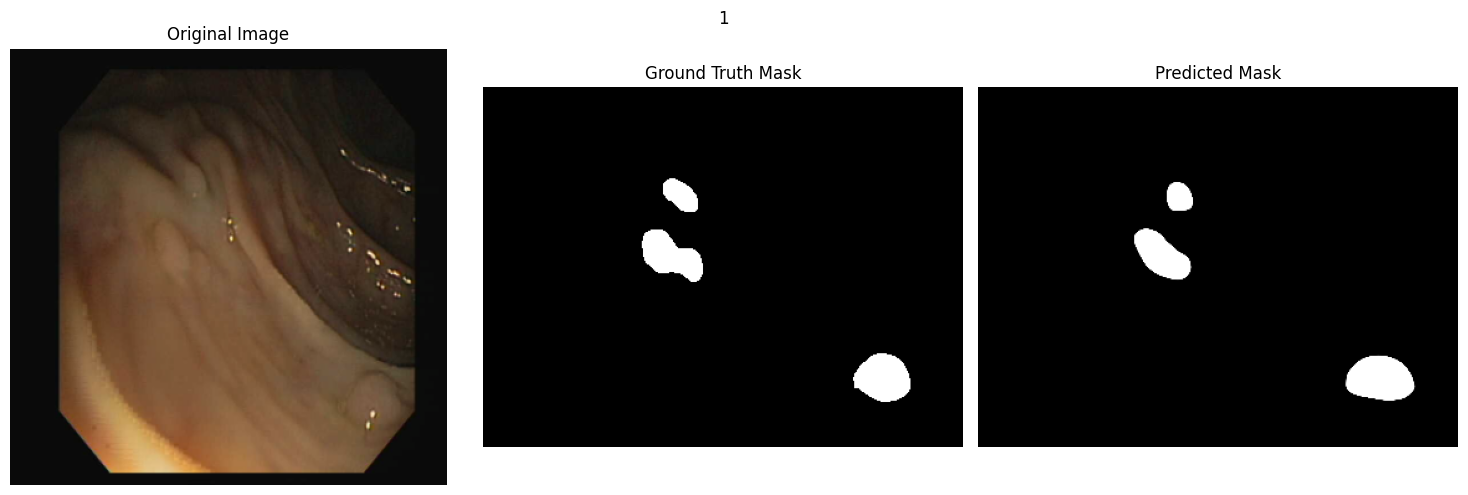

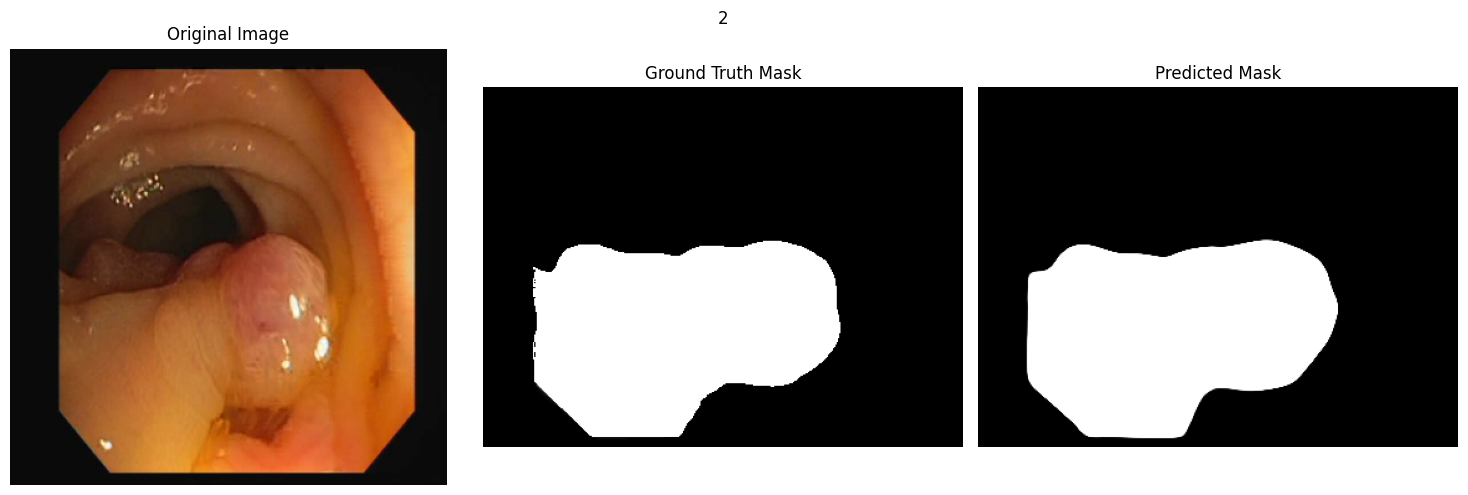

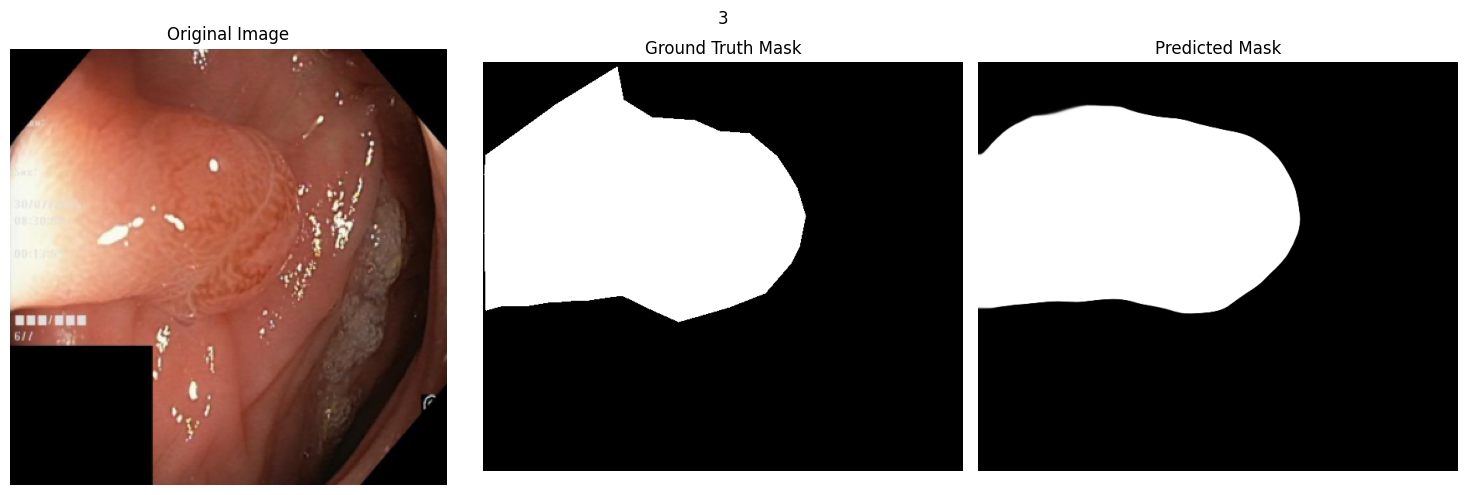

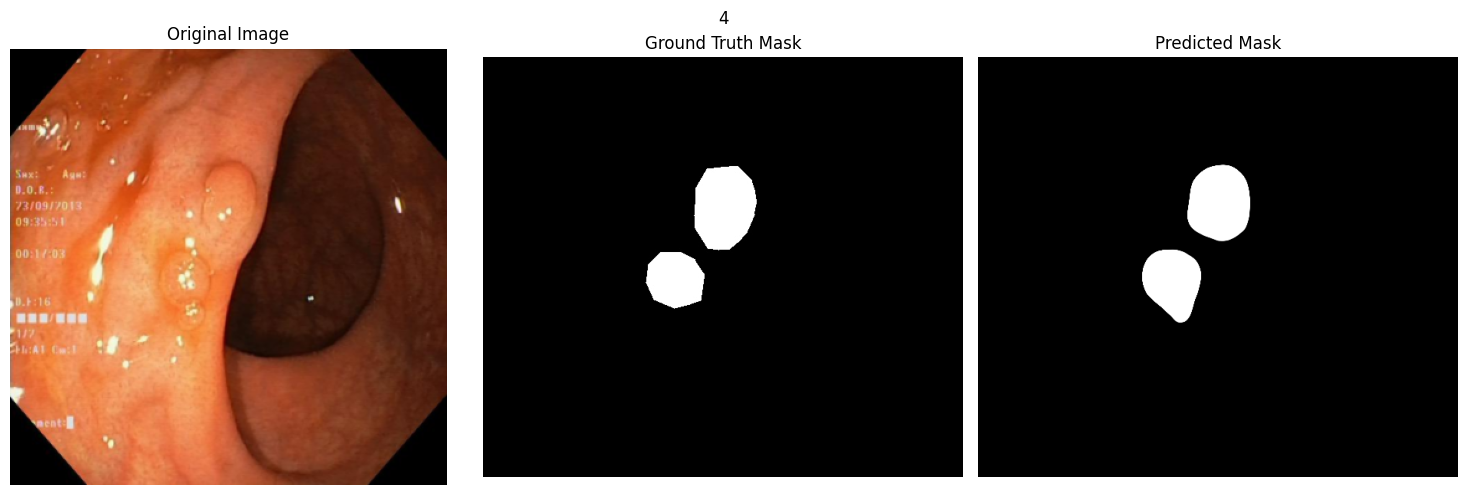

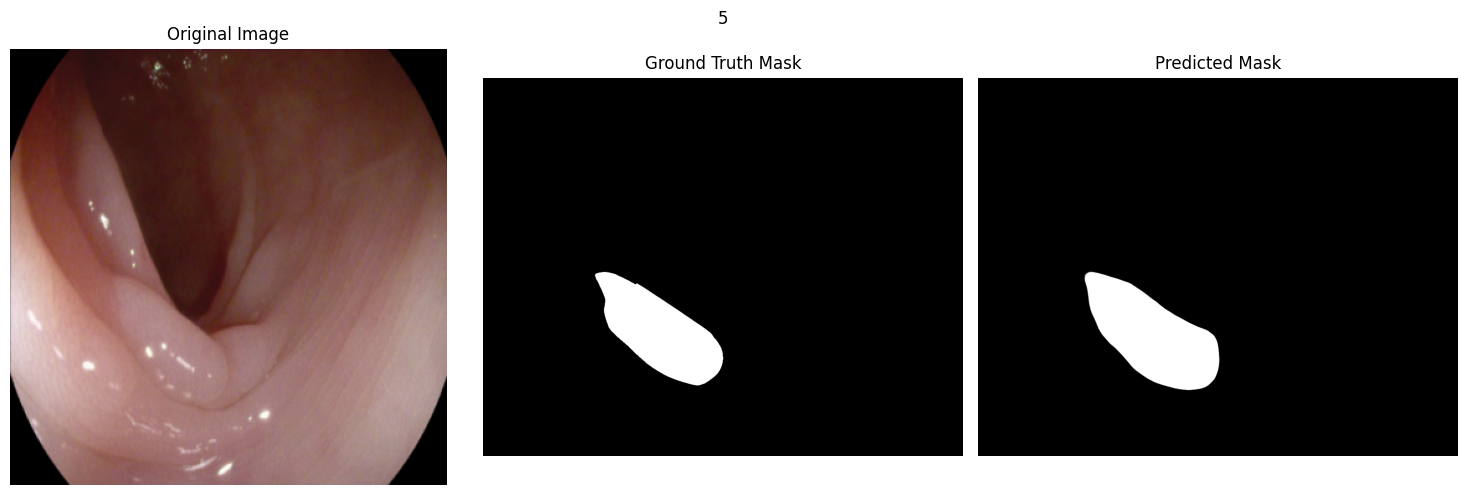

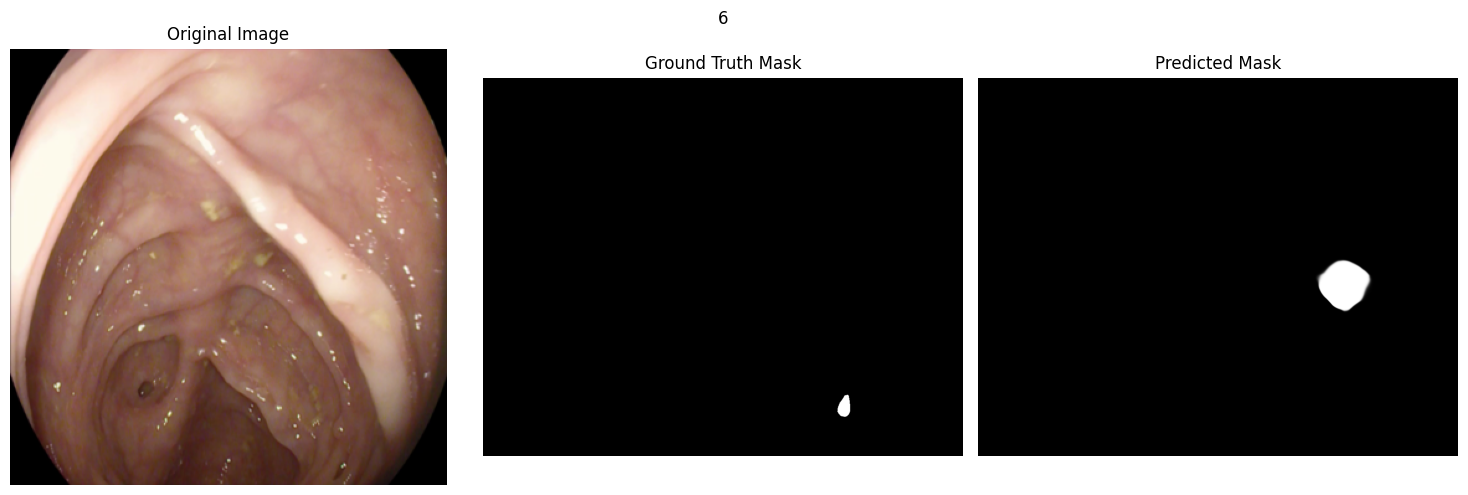

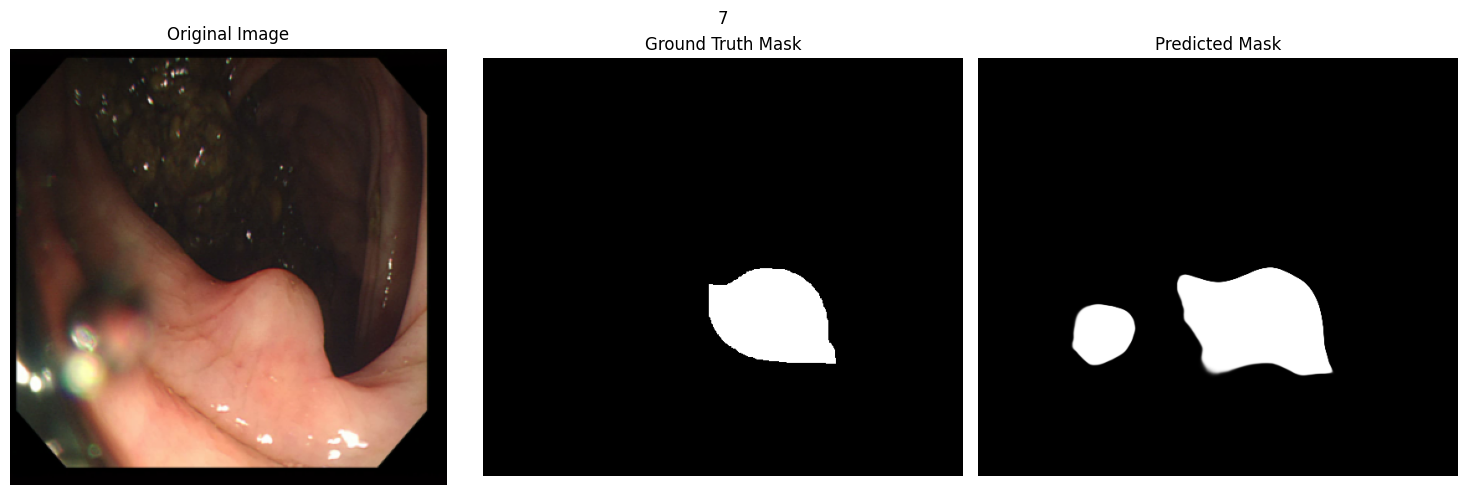

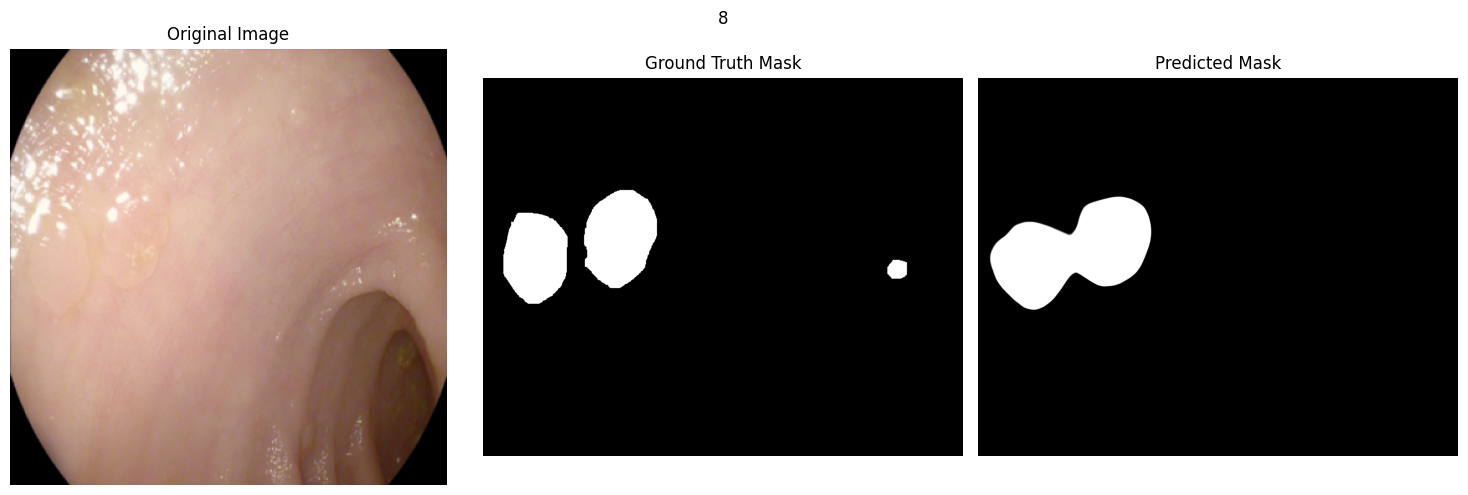

In [19]:
import torch
import torch.nn.functional as F
import numpy as np
import os
import argparse
from scipy import misc 
from lib.HSFNet import HSFNet

from utils.dataloader import test_dataset
import matplotlib.pyplot as plt

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--testsize', type=int, default=352, help='testing size')
    parser.add_argument('--pth_path', type=str, default='/home/qyl/HSFNet/model_pth/best.pth')
    opt = parser.parse_args(args=[])
    model = HSFNet()
    model.load_state_dict(torch.load(opt.pth_path))
    model.cuda()
    model.eval()

    image_root = '/home/qyl/HSFNet/results/images/'
    gt_root = '/home/qyl/HSFNet/results/masks/'

    num1 = len(os.listdir(gt_root))
    test_loader = test_dataset(image_root, gt_root, 352)

    for i in range(num1):

        image, gt, name = test_loader.load_data()
    
        gt = np.asarray(gt, np.float32)
        gt /= (gt.max() + 1e-8)
        
        image_for_model = image.cuda()
        
        with torch.no_grad(): 
            P1, P2, P3, P4 = model(image_for_model)

        res = F.interpolate(P1 + P2 + P3 + P4, size=gt.shape, mode='bilinear', align_corners=False)
        res = res.sigmoid().data.cpu().numpy().squeeze()
        res = (res - res.min()) / (res.max() - res.min() + 1e-8)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        original_img_display = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        original_img_display = std * original_img_display + mean
        original_img_display = np.clip(original_img_display, 0, 1)
        
        axes[0].imshow(original_img_display)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        axes[1].imshow(gt, cmap='gray')
        axes[1].set_title('Ground Truth Mask')
        axes[1].axis('off')

        axes[2].imshow(res, cmap='gray')
        axes[2].set_title('Predicted Mask')
        axes[2].axis('off')
        
        plt.suptitle(f'{i+1}')
        plt.tight_layout()
        plt.show()
